In [1]:
import numpy as np

# Physical parameters
mtot = 0.943
m_motor = 0.052
m_prop  = 0.01
mr = m_motor + m_prop
md = mtot - 4*(m_motor + m_prop)
L = 0.225   # arm length
I_single = (m_motor + m_prop) * L**2

h1 = 1
g = 9.81
rho = 1.225

k_drag = 1e-6

Ixx = 2 * I_single
Iyy = 2 * I_single
Izz = 4 * I_single

omega_hover = 400
k_thrust = mtot * g / (4 * omega_hover**2)

params = {
    "mtot": mtot, "md": md, "mr": mr,
    "I": I_single, "h1": h1, "g": g, "rho": rho,
    "L": L, "omega_hover": omega_hover,
    "k_thrust": k_thrust, "k_drag": k_drag,
    "Ixx": Ixx, "Iyy": Iyy, "Izz": Izz
}


In [2]:
def rotation(phi, theta, psi):
    cphi, sphi = np.cos(phi), np.sin(phi)
    cth,  sth  = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    return np.array([
        [cth*cpsi,  cth*spsi, -sth],
        [sphi*sth*cpsi - cphi*spsi, sphi*sth*spsi + cphi*cpsi, sphi*cth],
        [cphi*sth*cpsi + sphi*spsi, cphi*sth*spsi - sphi*cpsi, cphi*cth]
    ])


In [3]:
def euler_rates(phi, theta, psi, p, q, r):
    phi_dot   = p + q*np.sin(phi)*np.tan(theta) + r*np.cos(phi)*np.tan(theta)
    theta_dot =     q*np.cos(phi)               - r*np.sin(phi)
    psi_dot   =     q*np.sin(phi)/np.cos(theta) + r*np.cos(phi)/np.cos(theta)
    return np.array([phi_dot, theta_dot, psi_dot])


In [4]:
def thrust_body(omegas):
    kT = params["k_thrust"]
    return np.array([0, 0, kT * np.sum(omegas**2)])

def torque_body(omegas):
    L = params["L"]
    kT = params["k_thrust"]
    b = params["k_drag"]

    w1, w2, w3, w4 = omegas
    tau_phi   = L * kT * (w1**2 - w3**2)
    tau_theta = L * kT * (w2**2 - w4**2)
    tau_psi   = b * (w1**2 - w2**2 + w3**2 - w4**2)

    return np.array([tau_phi, tau_theta, tau_psi])


In [5]:
def acceleration(omega_sq, angles, xdot, params):
    m = params["mtot"]
    g = params["g"]
    kT = params["k_thrust"]

    phi, theta, psi = angles
    R = rotation(phi, theta, psi)

    thrust = np.array([0, 0, kT * np.sum(omega_sq**2)])
    T_I = R @ thrust
    gravity = np.array([0, 0, -g])

    return gravity + T_I/m


def angular_acceleration(omega_sq, omega, params):
    p, q, r = omega
    Ixx, Iyy, Izz = params["Ixx"], params["Iyy"], params["Izz"]

    tau = torque_body(omega_sq)
    tau_phi, tau_theta, tau_psi = tau

    p_dot = (tau_phi   / Ixx) - ((Iyy - Izz)/Ixx) * q * r
    q_dot = (tau_theta / Iyy) - ((Izz - Ixx)/Iyy) * p * r
    r_dot = (tau_psi   / Izz) - ((Ixx - Iyy)/Izz) * p * q

    return np.array([p_dot, q_dot, r_dot])


In [17]:
dt = 0.005
start_time = 0
end_time = 120  # or however long you want
times = np.arange(start_time, end_time, dt)

# State storage
Xs = []
Vels = []
Angles = []
Omegas = []

# Initial conditions
x = np.array([0., 0., 0.])
xdot = np.zeros(3)
angles = np.zeros(3)
omega = np.zeros(3)    # NO random disturbance

def input_func(t):
    return np.array([400, 400, 400, 400])  # constant hover

for t in times:
    omegas = input_func(t)

    a = acceleration(omegas, angles, xdot, params)
    omegadot = angular_acceleration(omegas, omega, params)

    omega += dt * omegadot
    angles += dt * euler_rates(*angles, *omega)
    xdot += dt * a
    x += dt * xdot

    # store
    Xs.append(x.copy())
    Vels.append(xdot.copy())
    Angles.append(angles.copy())
    Omegas.append(omega.copy())

Xs = np.array(Xs)
Angles = np.array(Angles)
Omegas = np.array(Omegas)


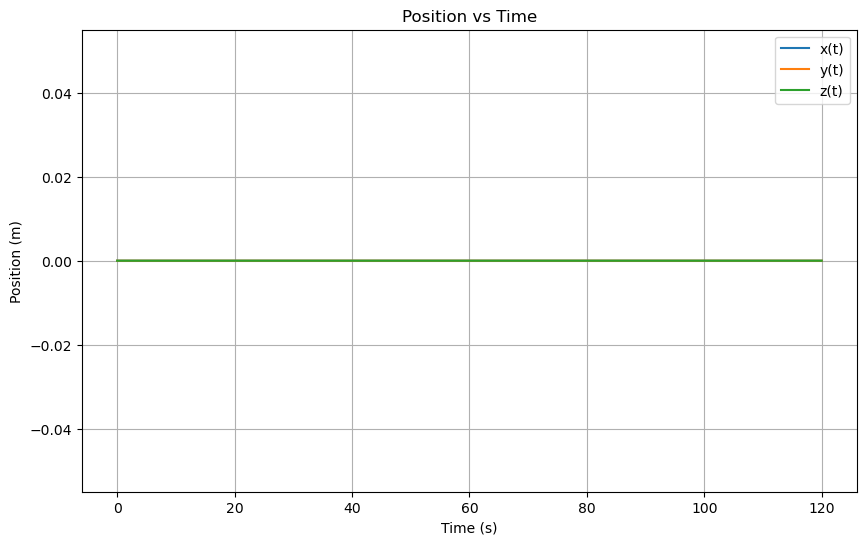

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(times, Xs[:,0], label="x(t)")
plt.plot(times, Xs[:,1], label="y(t)")
plt.plot(times, Xs[:,2], label="z(t)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position vs Time")
plt.legend()
plt.grid(True)
plt.show()


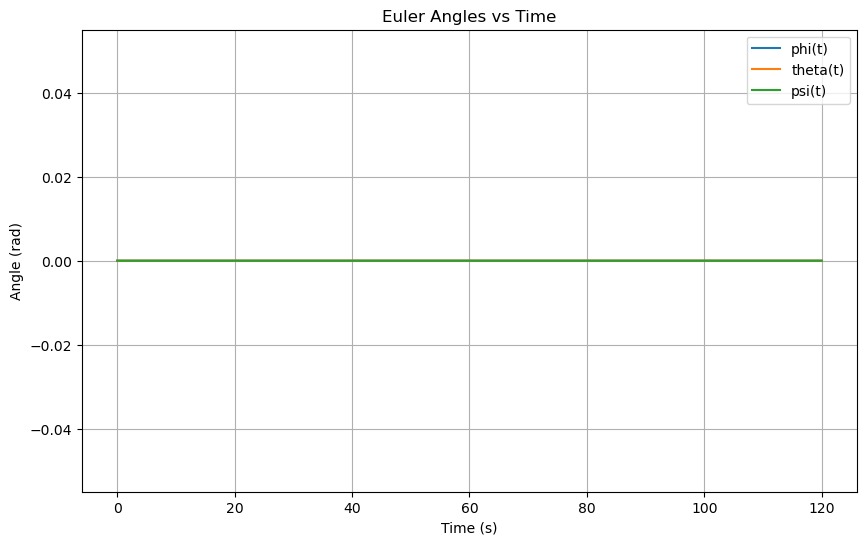

In [19]:
plt.figure(figsize=(10,6))
plt.plot(times, Angles[:,0], label="phi(t)")
plt.plot(times, Angles[:,1], label="theta(t)")
plt.plot(times, Angles[:,2], label="psi(t)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Euler Angles vs Time")
plt.legend()
plt.grid(True)
plt.show()


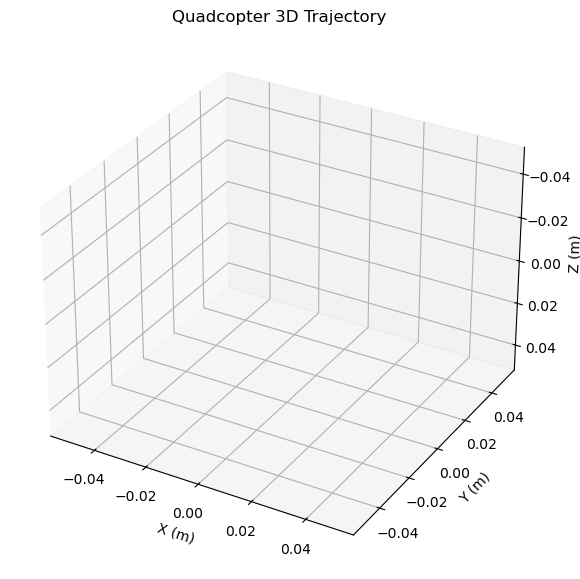

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs[:,0], Xs[:,1], Xs[:,2], linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Quadcopter 3D Trajectory')
ax.invert_zaxis()
plt.show()


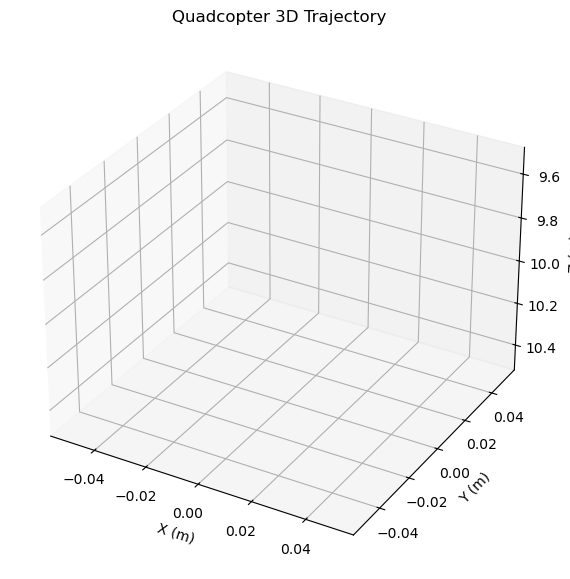

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs[:,0], Xs[:,1], Xs[:,2], linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Quadcopter 3D Trajectory')
ax.invert_zaxis()  # optional: make height go up visually
plt.show()


In [21]:
def hover_input(t):
    """
    Constant rotor speeds equal to hover rpm.
    From: 4 * k_thrust * omega_hover^2 = m g
    """
    omega_h = params["omega_hover"]
    return np.array([omega_h, omega_h, omega_h, omega_h])


In [23]:
def simulate_hover(T=120.0, dt=0.005):
    """
    Simulate hover for duration T (seconds) with timestep dt.
    Returns:
      times, Xs, Angles, Omegas_body
    """
    times = np.arange(0.0, T+dt, dt)

    # Initial state: hover 1 m above ground
    x      = np.array([0.0, 0.0, 1.0])    # <-- REQUIRED
    xdot   = np.zeros(3)                  # linear velocity
    angles = np.zeros(3)                  # phi, theta, psi
    omega_body = np.zeros(3)              # p, q, r (body rates)

    # Storage
    N = len(times)
    Xs = np.zeros((N, 3))
    Angles_arr = np.zeros((N, 3))
    Omegas_arr = np.zeros((N, 3))

    for i, t in enumerate(times):

        # constant hover rotor speeds
        omegas = hover_input(t)

        # accelerations
        a = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        # integrate rotational motion
        omega_body = omega_body + dt * omegadot
        angles     = angles + dt * euler_rates(*angles, *omega_body)

        # integrate linear motion
        xdot = xdot + dt * a
        x    = x    + dt * xdot

        # log data
        Xs[i,:] = x
        Angles_arr[i,:] = angles
        Omegas_arr[i,:] = omega_body

    return times, Xs, Angles_arr, Omegas_arr


In [24]:
# --- Run Hover Simulation ---
T_hover = 120.0     # 2 minutes
dt       = 0.005

times, Xs_hov, Angles_hov, Omegas_hov = simulate_hover(T=T_hover, dt=dt)


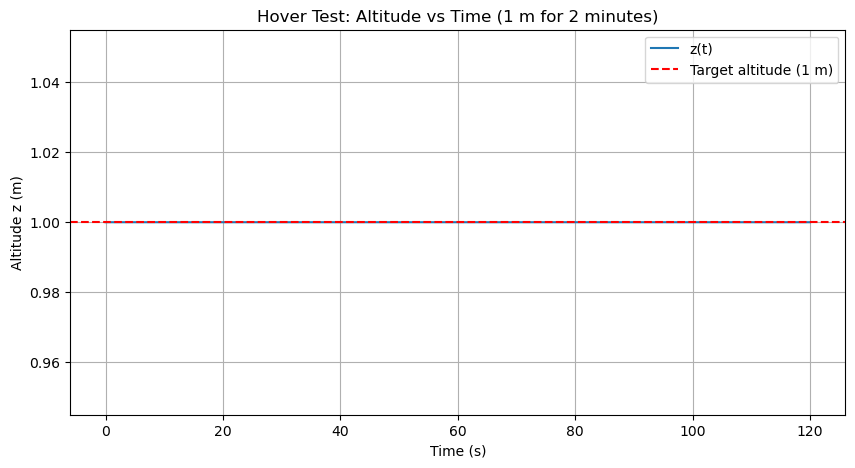

In [25]:
plt.figure(figsize=(10,5))
plt.plot(times, Xs_hov[:,2], label="z(t)")
plt.axhline(1.0, color='r', linestyle='--', label="Target altitude (1 m)")
plt.xlabel("Time (s)")
plt.ylabel("Altitude z (m)")
plt.title("Hover Test: Altitude vs Time (1 m for 2 minutes)")
plt.grid(True)
plt.legend()
plt.show()


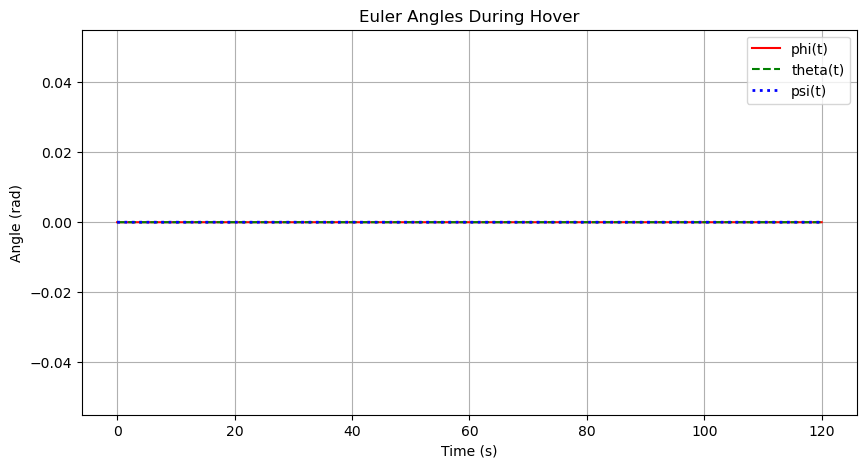

In [30]:
plt.figure(figsize=(10,5))
plt.plot(times, Angles_hov[:,0], 'r-',  linewidth=1.5, label='phi(t)')
plt.plot(times, Angles_hov[:,1], 'g--', linewidth=1.5, label='theta(t)')
plt.plot(times, Angles_hov[:,2], 'b:',  linewidth=2.0, label='psi(t)')

plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Euler Angles During Hover")
plt.grid(True)
plt.legend()
plt.show()


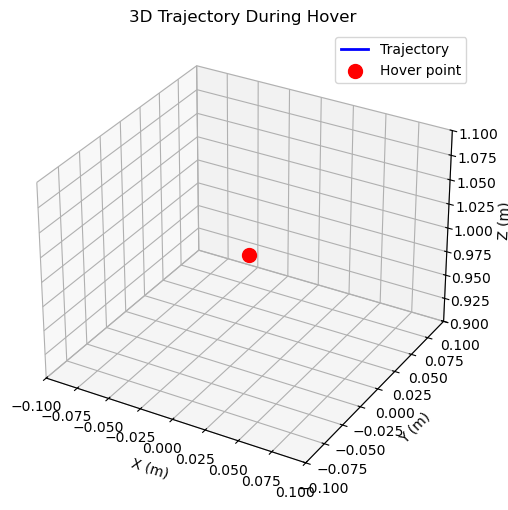

In [29]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory (basically a tiny cloud)
ax.plot(Xs_hov[:,0], Xs_hov[:,1], Xs_hov[:,2], 
        color='blue', linewidth=2, label="Trajectory")

# Plot the hover point as a big marker
ax.scatter(Xs_hov[-1,0], Xs_hov[-1,1], Xs_hov[-1,2],
           color='red', s=100, label="Hover point")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("3D Trajectory During Hover")

# Make axes "equal scale" so it's visible
max_range = 0.1
ax.set_xlim(-max_range, max_range)
ax.set_ylim(-max_range, max_range)
ax.set_zlim(1 - max_range, 1 + max_range)

ax.legend()
plt.show()


In [48]:
def motor_speeds_from_thrust_torques(T, tau_phi, tau_theta, tau_psi, params=params):
    """
    Given desired total thrust T and body torques (tau_phi, tau_theta, tau_psi),
    solve for the rotor speeds [ω1, ω2, ω3, ω4].

    Returns ω's in rad/s.
    """
    kT = params["k_thrust"]
    L  = params["L"]
    b  = params["k_drag"]

    A = np.array([
        [ kT,      kT,      kT,      kT     ],
        [ L*kT,    0.0,    -L*kT,    0.0    ],
        [ 0.0,     L*kT,    0.0,    -L*kT   ],
        [ b,      -b,       b,      -b      ]
    ])

    u = np.array([T, tau_phi, tau_theta, tau_psi])

    # solve A * [ω1², ω2², ω3², ω4²] = u
    omega_sq = np.linalg.solve(A, u)

    # numerical safety: no negative due to tiny floating noise
    omega_sq = np.clip(omega_sq, 0.0, None)

    return np.sqrt(omega_sq)


In [49]:
def rotation(phi, theta, psi):
    cphi, sphi = np.cos(phi), np.sin(phi)
    cth,  sth  = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    R = np.array([
        [cpsi*cth,  spsi*cth,  -sth],
        [cpsi*sth*sphi - spsi*cphi,  spsi*sth*sphi + cpsi*cphi,  cth*sphi],
        [cpsi*sth*cphi + spsi*sphi,  spsi*sth*cphi - cpsi*sphi,  cth*cphi]
    ])
    return R


In [50]:
def simulate_circle(T=60.0, dt=0.01):
    R_path = 2.0
    v = 0.5
    Omega_c = v / R_path

    # pull mass and gravity from params
    m = params["mtot"]
    g = params["g"]

    times = np.arange(0., T, dt)

    x = np.array([R_path, 0.0, 1.0])
    xdot = np.array([0.0, v, 0.0])
    angles = np.zeros(3)
    omega_body = np.zeros(3)

    Xs = np.zeros((len(times),3))
    Angles_log = np.zeros((len(times),3))

    for i, t in enumerate(times):
        phi, theta, psi = angles
        p, q, r = omega_body

        # desired yaw
        psi_des = Omega_c * t

        # desired roll for centripetal acceleration
        a_c = v*v/R_path
        phi_des = np.arcsin(a_c / g)
        theta_des = 0.0

        # errors
        e_phi   = phi_des - phi
        e_theta = theta_des - theta
        e_psi   = psi_des - psi

        # PD torques
        tau_phi   = 0.8*e_phi   - 0.1*p
        tau_theta = 0.8*e_theta - 0.1*q
        tau_psi   = 5.0*e_psi   - 0.2*r

        # tilt compensation (IMPORTANT)
        T_des = m * g / (np.cos(phi)*np.cos(theta) + 1e-6)

        # rotor speeds
        omegas = motor_speeds_from_thrust_torques(T_des, tau_phi, tau_theta, tau_psi)

        # dynamics
        a = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        omega_body += dt * omegadot
        angles     += dt * euler_rates(*angles, *omega_body)
        xdot       += dt * a
        x          += dt * xdot

        Xs[i] = x
        Angles_log[i] = angles

    return times, Xs, Angles_log

times_circ, Xs_circ, Angles_circ = simulate_circle()


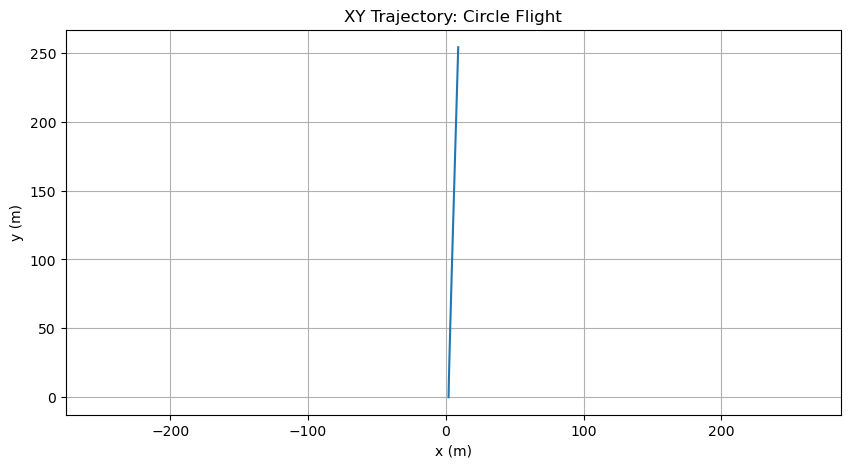

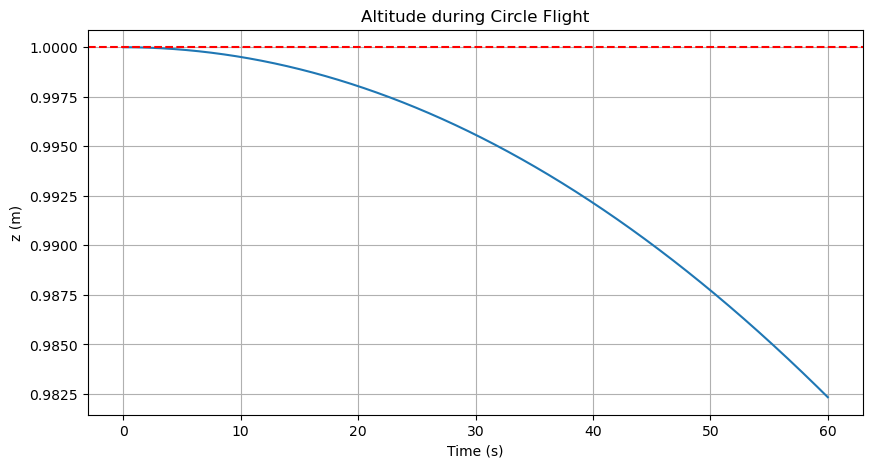

In [51]:
plt.figure(figsize=(10,5))
plt.plot(Xs_circ[:,0], Xs_circ[:,1])
plt.axis('equal')
plt.title("XY Trajectory: Circle Flight")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(times_circ, Xs_circ[:,2])
plt.axhline(1.0, color='red', linestyle='--')
plt.title("Altitude during Circle Flight")
plt.xlabel("Time (s)")
plt.ylabel("z (m)")
plt.grid(True)
plt.show()
